# Creating a spherical distribution for treecode
The code generating the spherical distribution is the same as for nbody, what changes is the writing of the input file and of the command line.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
N = 10000 #number of particles
a = 15 #sphere radius
M = 10000 #sphere total mass
n_dim = 3 #number of dimensions
inputname = 'input.txt'
outputname = 'output.txt'

We want to generate N particles distributed symmetrically. In order to do this, we use the inverse probability theorem: we generate points from a uniform distribution and pass them through the inverse formula of the original probability density.
We will do this in polar coordinates and then switch to cartesian ones to write the imput file.

### Radius distribution
As for the radius, our probability density is:
$$p(r) = \frac{3r^2}{a^3}$$

where a is the radius of the sphere. This means that the integral is:
$$P(r') = \int_{-\infty}^{r'} \frac{3{r}^2}{a^3} dr = \int_{-\infty}^{0} 0 \, + \int_{0}^{r'} \frac{3{r}^2}{a^3} dr = \frac{{r'}^3}{a^3}$$

and the inverse is:

$$r' = (a^3 P)^{1/3}$$

we then generate P $\in$ [0, 1] and find r.

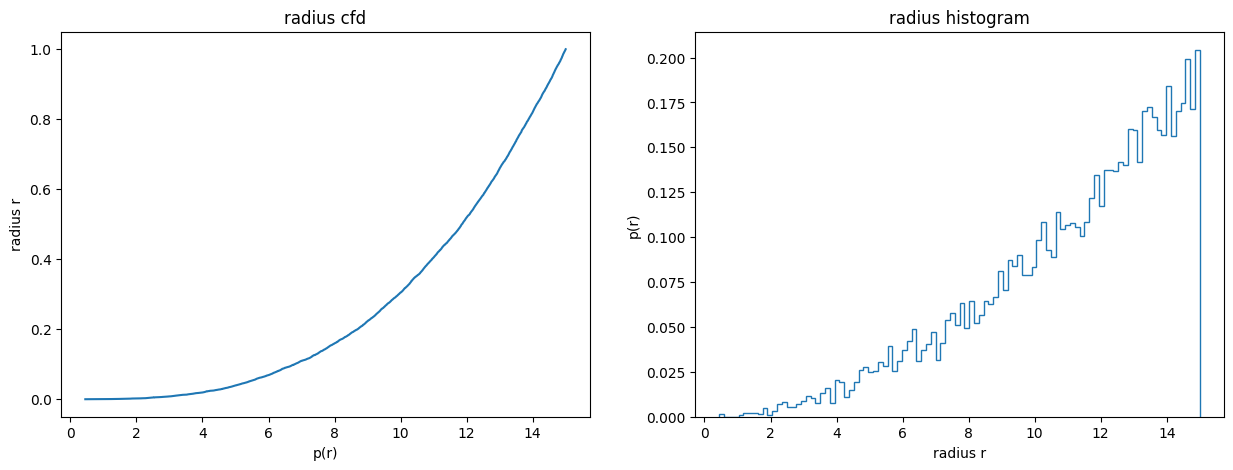

In [4]:
P_r = np.random.uniform(0, 1, N)

radius = a * np.power(P_r, 1/3)
radius_s = radius.copy()
radius_s.sort()

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(121)
ax.plot(radius_s, np.linspace(0,1,N))
ax.set(xlabel='p(r)', ylabel='radius r', title='radius cfd') 

ax = fig.add_subplot(122)
ax.hist(radius, int(np.sqrt(N)), histtype = 'step', density = True)
ax.set(ylabel='p(r)', xlabel='radius r', title='radius histogram') 

plt.show()

### Phi distribution
$\phi$ is distributed uniformly and normalised with $2\pi$.

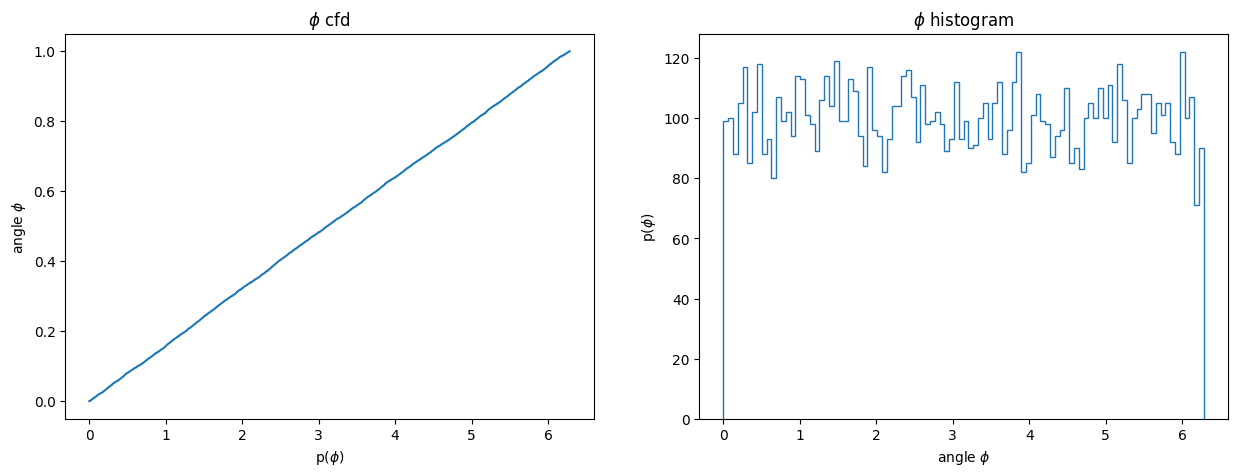

In [5]:
phi = np.random.uniform(0, 2*np.pi, N)
phi_s = phi.copy()
phi_s.sort()

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(121)
ax.plot(phi_s, np.linspace(0,1,N))
ax.set(xlabel='p($\phi$)', ylabel='angle $\phi$', title='$\phi$ cfd') 

ax = fig.add_subplot(122)
ax.hist(phi, int(np.sqrt(N)), histtype = 'step')
ax.set(ylabel='p($\phi$)', xlabel='angle $\phi$', title='$\phi$ histogram')

plt.show()

### Theta distribution
Finally, $\theta$ is distributed as:
$$p(\theta) = sin(\theta)$$
and its inverse probability distribution is:
$$\theta = arccos(1 - 2P)$$

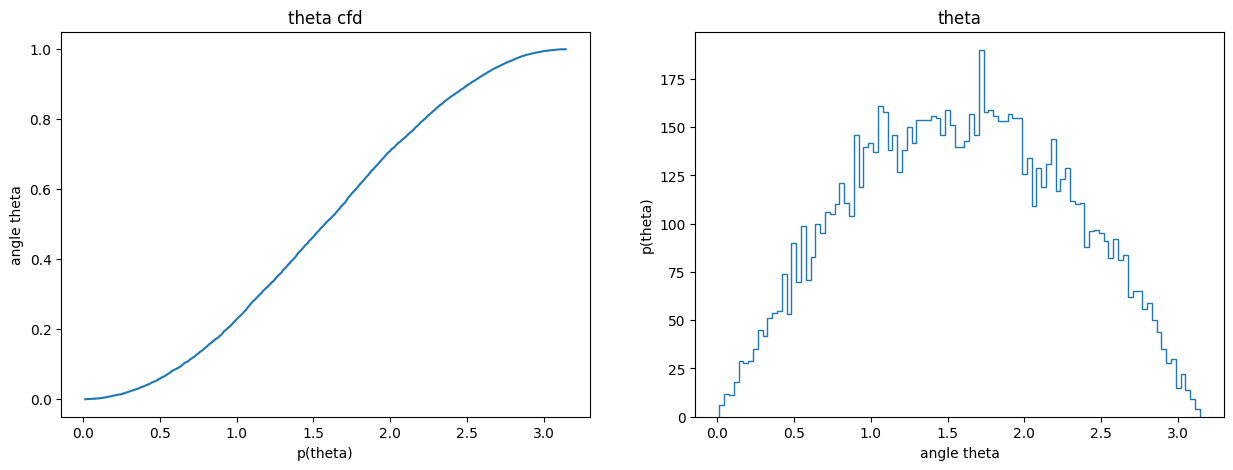

In [6]:
P_theta = np.random.uniform(0, 1, N)
theta = np.arccos(1 - 2 * P_theta)
theta_s = theta.copy()
theta_s.sort()

fig = plt.figure(figsize = (15, 5))
ax = fig.add_subplot(121)
ax.plot(theta_s, np.linspace(0,1,N))
ax.set(xlabel='p(theta)', ylabel='angle theta', title='theta cfd') 

ax = fig.add_subplot(122)
ax.hist(theta, int(np.sqrt(N)), histtype = 'step')
ax.set(ylabel='p(theta)', xlabel='angle theta', title='theta') 

plt.show()

### Creating the treecode input
We finally need to convert our values into carthesian coordinates and finally print them into a .txt file.

In [7]:
def polar_to_carth(radius, theta, phi):
    x = radius * np.sin(theta) * np.cos(phi)
    y = radius * np.sin(theta) * np.sin(phi)
    z = radius * np.cos(theta)
    return x, y, z

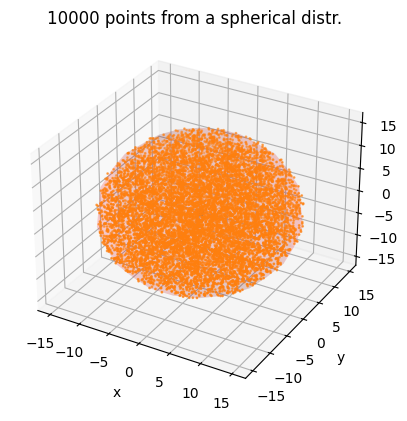

14.894385797566695 14.887005754681665 14.831493510515605


In [8]:
x, y, z = polar_to_carth(radius, theta, phi)

fig = plt.figure()

#points
ax = fig.add_subplot(projection='3d')
ax.scatter(0, 0, 0)
ax.scatter(x, y, z, s=1)

#sphere of radius a 
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
xs, ys, zs = polar_to_carth (a, u, v)
ax.plot_surface(xs, ys, zs, color="r", alpha = 0.1)

ax.set(xlabel='x', ylabel='y', zlabel='z', title=str(N) + ' points from a spherical distr.')

plt.show()

print(x.max(), y.max(), z.max())

### Creating the .txt file
We will need the number of particles (N), the number of dimentions (n_dim), the starting time (fixed to 0), the mass of the particles (all equal and chosen by the user depending on total mass), the points we have generated and finally the velocities (all 0 at the start)

In [9]:
inputf = open(inputname, 'w')

particles_masses = ''
particles_positions = ''
particles_velocities = ''

for i in range(N):
    particles_masses = particles_masses + str(M/N) + '\n'
    particles_positions = particles_positions + str(x[i]) + ' ' + str(y[i]) + ' ' + str(z[i]) + '\n'
    particles_velocities = particles_velocities + '0 0 0\n'
    

lines = [str(N) + '\n' + str(n_dim) + '\n0\n' + particles_masses + particles_positions + particles_velocities]
inputf.writelines(lines)

inputf.close()

### Command line parameters
To put all together, we can now compute useful parameters to run the nbody code. We recall that the command line is as follows:

treecode IN = input_name OUT = output_name dTIME = h EPS = softening_value THETA = accuracy_parameter TSTOP = max_time DTOUT = output_frequency

In [17]:
dtime = 0 #timestep
eps = 0.025 #softening value
theta_p = 0.05 #accuracy parameter (= 3 degrees in this case)
tstop = 0 #max time
dtout = 0 #output frequency

n_repetitions = 1.5 #repetition of the system (start to collapse(1) and back(2))
n_out = 100 #n of snapshots

In [18]:
sphere_V = 4 * np.power(a, 3) / (3*np.pi)
sphere_density = (M)/sphere_V

dyn_time = np.sqrt((3 * np.pi)/(16*sphere_density))
collapse_time = dyn_time * np.power(2, -1/2)
print(collapse_time)

tstop = (collapse_time + collapse_time/5) * n_repetitions

dtout = tstop/n_out
dtime = tstop / 10000

commandf = open('command_line.txt', 'a')
commandf.write('\ntreecode IN=' + inputname + ' OUT=' + outputname + ' dTIME=' + str(dtime) + ' EPS=' + str(eps) + ' THETA=' + str(theta_p) + ' TSTOP=' + str(tstop) + ' DTOUT=' + str(dtout))
commandf.close()

0.2053959590644373


### Physical values of useful quantities
We convert all the relevant quantities in physical values, as up to now we have expressed them in internal units.

In [19]:
from astropy import constants as const
from astropy import units as u

G = const.G.cgs
kpc = const.kpc.cgs
M_sun = const.M_sun.cgs

In [20]:
print('Total sphere mass = ', M * M_sun, '\nElement mass = ', M*M_sun/N)

sphere_V = 4 * np.power(a * kpc, 3) / (3*np.pi)
print('\nSphere volume = ', sphere_V)

sphere_density = (M * M_sun)/sphere_V
print('\nSphere density = ', sphere_density)

dyn_time = np.sqrt((3 * np.pi)/(16 * G * sphere_density))
print('\nDynamical time = ', dyn_time)

collapse_time = dyn_time * np.power(2, -1/2)

print('\nCollapse time = ', collapse_time)

Total sphere mass =  1.988409870698051e+37 g 
Element mass =  1.988409870698051e+33 g

Sphere volume =  4.208373495630113e+67 cm3

Sphere density =  4.724889254156681e-31 g / cm3

Dynamical time =  4.321921692163098e+18 s

Collapse time =  3.056060136285765e+18 s
